In [1]:
#Some test to exxtract stanford dataset
#!pip install dash-leaflet
#!pip install obspy
#!pip install dash-extensions
#!pip install librosa
#!pip install dash-bootstrap-components
#!pip install geopy

In [2]:
#Statistics layer: heatmap by geographic regions, heatmap by countries
# Global regions: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/CQWUBI

In [3]:
#!pip install dash-extensions==0.0.65

In [4]:
from map_helper_functions import *


df_events = pd.read_csv("csvs/earthquake_metadata.csv",low_memory=False)

df_events.set_index('trace_name',inplace= True)

In [5]:
provider_list = sorted(URL_MAPPINGS.keys())

In [6]:
df_events['time'] = pd.to_datetime(df_events['trace_start_time'], infer_datetime_format=True)
df_events['source_depth_km'] = pd.to_numeric(df_events['source_depth_km'],errors='coerce')
df_events['source_magnitude'] = pd.to_numeric(df_events['source_magnitude'],errors='coerce')

In [7]:
#stations_df = pd.read_csv('stations_duplicates_removed.csv')
stations_df = pd.read_csv('csvs/stations_definition.csv')
stations_df['station_opened'] =  pd.to_datetime(stations_df['station_opened'], infer_datetime_format=True)

#df_events
#stations_df = stations_df
#stations_df[
stations_df = stations_df[stations_df['station_id'].isin(stations)]
stations_df.to_csv('csvs/stations_definition.csv',index = False)

In [8]:
selected_event = df_events.loc['KAN08.GS_20150408005359_EV']

provider_of_waveform = stations_df[stations_df['station_id'] == selected_event['station_id']]

clien = provider_of_waveform['provider'].tolist()[0]

In [9]:
clien = Client(clien)
wave_test = extract_waveform(clien, selected_event)


In [10]:
def create_waveform_spectrogram_1(waveform):
    px = 1/plt.rcParams['figure.dpi']
    #wf = fig_to_uri(waveform)

    fig = plt.figure(figsize=(800*px, 500*px))
    ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.4]) #[left bottom width height]
    ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.50],sharex = ax1)
    ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.5])

    #make time vector
    t = np.arange(wave_test.stats.npts) / wave_test.stats.sampling_rate
    time_split = np.arange(np.datetime64(waveform.stats['starttime']), np.datetime64(waveform.stats['endtime']), timedelta(seconds=10)).astype('datetime64[s]')
    #plot waveform (top subfigure)    
    ax1.plot(t, wave_test.data, 'k')
    #ax1.plot(wave_test.data)
    ax1.set_xticks(np.arange(0,60)[::10])
    ax1.set_xticklabels(time_split)
    ax1.get_xaxis().set_visible(False)

    #plot spectrogram (bottom subfigure)
    #spl2 = wave_test
    #spl2.spectrogram(show=False, axes=ax2)
    ax2.specgram(x = wave_test.filter("highpass", freq=0.5).data, Fs = wave_test.stats.sampling_rate,scale = 'dB',cmap = 'viridis')
    ax2.set_xlabel('Time [sec]')
    ax2.set_ylabel('Frequency [Hz]')
    #ax2.set_title('')
    ax2.set_xticks(np.arange(0,60)[::10])
    ax2.set_xticklabels(time_split,rotation=45)
    mappable = ax2.images[0]
    plt.colorbar(mappable=mappable, cax=ax3,label = 'Amplitude (dB)')
    

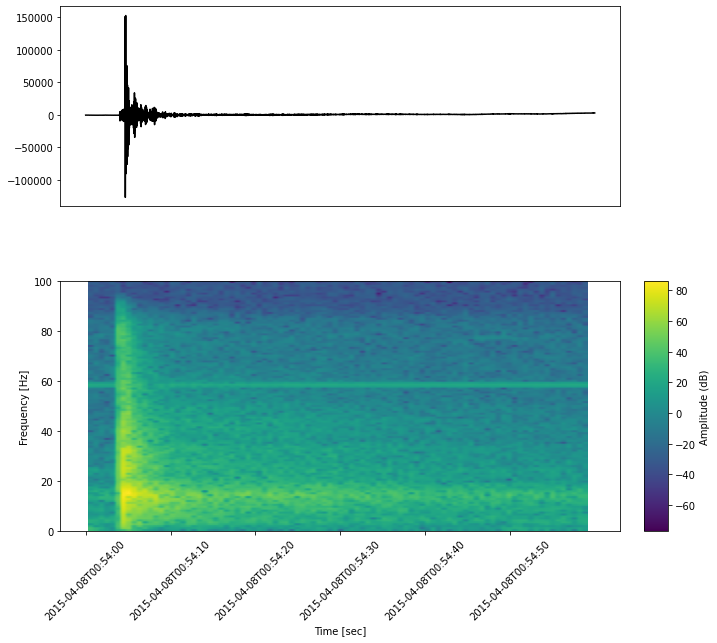

In [11]:
create_waveform_spectrogram_1(wave_test)

create_waveform_spectrogram_1(wave_test)

In [12]:
o_file = create_seismic_sound_to_dash_bytes(wave_test)
spectrogram_plot = spectrogram_to_uri(wave_test)

base_seismogram = fig_to_uri(wave_test)

In [13]:
new_wave_spectrogram = create_waveform_spectrogram(wave_test)

C:\Users\Andras\AppData\Local\Temp\ipykernel_17168\4175460682.py:1: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  plt.imshow(plt.imread(new_wave_spectrogram))


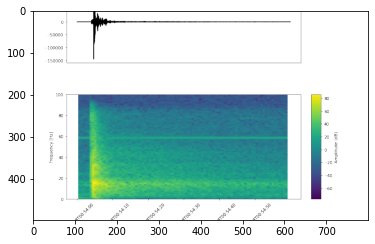

In [14]:
#plt.imshow(plt.imread(new_wave_spectrogram))

Extract the minimum depth, magnitude, recording times etcc

In [13]:
#Latitudes and longitudes
site_lat = df_events.source_latitude
site_lon = df_events.source_longitude
hover_desc = 'Timestamp: ' +  str(df_events.time) + '<br>Category: ' + df_events.trace_category

#min timestamp
#Extract timestamp range
min_date = min(df_events['time']).date()
max_date = max(df_events['time']).date()
#Extract minimum and maximum depth
min_depth = min(df_events['source_depth_km'])
max_depth = max(df_events['source_depth_km'])
#Extract minimum and maximum magnitude
min_magnitude = min(df_events['source_magnitude'])
max_magnitude = max(df_events['source_magnitude'])

depth_space = np.linspace(start=min_depth,stop=max_depth,num=8,endpoint=True,dtype=np.float64)
magnitude_space = np.linspace(start=min_magnitude,stop=max_magnitude,num=8,endpoint=True,dtype=np.float64)

In [14]:
provider_list = stations_df['provider'].value_counts().index.tolist()

In [15]:
stations_geojson = stations_df_to_geojson(stations_df)

In [16]:
data_points_geojson = dataframe_to_geojson(df_events) 

In [17]:
import dash_leaflet as dl
from dash import Dash, html, dcc, Output, Input
from dash_extensions.javascript import assign
import dash_bootstrap_components as dbc
from dash import dash_table

import dash
from dash import dcc
from dash import html

from dash.dependencies import Input,Output,State
from dash import callback_context
import dash_leaflet as dl
from dash_extensions.javascript import assign


colorscale = ['red', 'yellow', 'green', 'blue', 'purple']  # rainbow
chroma = "https://cdnjs.cloudflare.com/ajax/libs/chroma-js/2.1.0/chroma.min.js"  # js lib used for colors
color_prop = 'source_magnitude'
colorbar = dl.Colorbar(colorscale=colorscale, width=20, height=150, min=min_magnitude, max=max_magnitude, unit='km')
detail_colorbar = dl.Colorbar(colorscale=colorscale, width=20, height=150,  unit='km', min=min_magnitude, max=max_magnitude, id = 'detail_map_colorbar')
# Geojson rendering logic, must be JavaScript as it is executed in clientside.
point_to_layer = assign("""function(feature, latlng, context){
    const {min, max, colorscale, circleOptions, colorProp} = context.props.hideout;
    const csc = chroma.scale(colorscale).domain([min, max]);  // chroma lib to construct colorscale
    circleOptions.fillColor = csc(feature.properties[colorProp]);  // set color based on color prop.
    return L.circleMarker(latlng, circleOptions);  // sender a simple circle marker.
}""")


#icons/antenna_img.png
# 
# `https://github.com/doromboziandras32/Interdisciplinary/blob/master/icons/antenna_img.png`
draw_antenna = assign("""function(feature, latlng){
const antenna = L.icon({iconUrl: `/static/antenna_img.png`, iconSize: [24,24]});
return L.marker(latlng, {icon: antenna});
}""")


draw_antenna_on_detail_map = assign("""function(feature, latlng){
const antenna = L.icon({iconUrl: `/static/antenna_img.png`, iconSize: [40,40]});
return L.marker(latlng, {icon: antenna});
}""")



#https://fonts.google.com/icons?selected=Material%20Icons%3Asettings_input_antenna%3A


#app = Dash(external_scripts=[chroma],external_stylesheets=[dbc.themes.BOOTSTRAP] ,prevent_initial_callbacks=True)
app = Dash(external_scripts=[chroma],external_stylesheets=[dbc.themes.MATERIA] ,prevent_initial_callbacks=True)

app.layout = html.Div([dbc.Row( id = 'filter-row', children = [#Filters|
                                html.Div(style={'marginLeft': 5,'display':'block','vertical-align': 'top'},
                                         children = [
                                            html.Div(style={ 'display': 'inline-block','vertical-align':'top', 'width':'25%', 'marginRight': '2%'},
                                                     children = [
                                                        html.H6('Providers',style = {'text-align': 'center'}),                                                     
                                                    #Datepicker to filter for intervals
                                                         dcc.Dropdown(id='provider-selector', 
                                                            options=[{'label': i, 'value': i} for i in provider_list],
                                                            multi=True, 
                                                            value = provider_list,
                                                            style={},
                                                            className='stockselector',
                                                            clearable=False,
                                                            placeholder = 'Select providers..',
                                                            
                                                            )]), 
                                            html.Div(style={ 'display': 'inline-block','vertical-align':'top', 'width':'20%', 'marginRight': '2%','text-align': 'center'},
                                                     children = [
                                                        html.H6('Date interval'),
                                                    #Datepicker to filter for intervals
                                                        dcc.DatePickerRange(
                                                            id='date-filter',
                                                            min_date_allowed=min_date,
                                                            max_date_allowed=max_date,
                                                            initial_visible_month=min_date,
                                                            start_date=min_date,
                                                            end_date=max_date
                                                        )]),
                                            html.Div(
                                                style={ 'display': 'inline-block','vertical-align':'top', 'width':'20%', 'marginRight': '2%','text-align': 'center'},                                                
                                                children = [
                                                html.H6('Earthquake depth interval (in km)'),
                                                #slider to filter for depth
                                                dcc.RangeSlider(min = min_depth, max = max_depth,
                                                                id='depth-slider',
                                                                marks={i: '{:.2f}'.format(i) for i in depth_space},
                                                                value=[min_depth, max_depth],
                                                                dots=False,
                                                                #step=
                                                                step=0.01,
                                                                updatemode='drag',
                                                                tooltip={"placement": "bottom", "always_visible": False}
                                            )]),
                                            html.Div(
                                                style={ 'display': 'inline-block','vertical-align':'top', 'width':'20%','text-align': 'center'},
                                                children = [
                                                html.H6('Earthquake magnitude interval (in km)'),
                                                #slider to filter for magnitudes
                                                dcc.RangeSlider(min = min_magnitude, max = max_magnitude,
                                                                id='magnitude-slider',
                                                                marks={i: '{:.2f}'.format(i) for i in magnitude_space},
                                                                value=[min_magnitude, max_magnitude],
                                                                dots=False,
                                                                step=0.01,
                                                                updatemode='drag',
                                                                tooltip={"placement": "bottom", "always_visible": False}
                                                                ),
                                                ])]),
                                             html.Div(
                                                  style={'display': 'block','text-align': 'center'},
                                                 children = [                                                      
                                                             dbc.Button('Apply Filters', id='filter-apply-btn', n_clicks=0, color = 'primary'),
                                                             dbc.Button('Reset Filters', id='filter-reset-btn', n_clicks=0, color = 'secondary')
                                                             ]
                                             )
                                         ]),
                        dbc.Row( id = 'map-row',
                                children =  [                          
                                dbc.Modal( 
                                            [
                                            dbc.ModalHeader(
                                                dbc.ModalTitle("Warning"), close_button=True
                                            ),
                                            dbc.ModalBody(
                                                "This modal has no close button and can't be dismissed by "
                                                "pressing ESC. Try clicking on the backdrop or the below "
                                                "close button.",
                                                id="event-no-match-alert"
                                            )
                                            ],
                                            id = "event-no-match-modal",
                                            is_open = False,
                                            centered=True
                                        ),
                                html.Div( 
                                        style={'width':'98%', 'marginRight': 0.8,'display':'inline-block',"border":"2px black solid"},                                                                                
                                        children = [dcc.RadioItems(options=[{
                                                                    'value':'simple','label': 'Simple-event view'},
                                                                    {'value':'multi', 'label': 'Event-Compare view'                                                            
                                                                    }],
                                                                    value='simple', id ='view-selector-radio',labelStyle={'display': 'inline-block',
                                                                                                                            'margin-left': '7px'}
                                                    )
                                            ,dl.Map(children=[
                                                    dl.TileLayer(),
                                                    dl.GeoJSON(data = data_points_geojson,
                                                    options=dict(pointToLayer=point_to_layer),  # how to draw points            
                                                    hideout=dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=10),
                                                    min=min_magnitude, max=max_magnitude, colorscale=colorscale),                                                    
                                                    cluster=True , zoomToBoundsOnClick=True,
                                                    superClusterOptions={"radius": 100},
                                                    
                                                    id ='earthquake_events_geojson'),
                                                    dl.GeoJSON(data=stations_geojson
                                                                , options=dict(pointToLayer=draw_antenna), zoomToBounds=True,
                                                                clusterToLayer=draw_antenna,
                                                                cluster=True ,  # how to draw clusters
                                                                zoomToBoundsOnClick=True,
                                                                superClusterOptions=dict(radius=150),
                                                                id= 'stations_geojson')  # when true, zooms to bounds of feature (e.g. cluster) on click)
                                                    ,colorbar                                                                
                                                ],
                                                 style={'width': '65%', 'height': '50vh', "display": "inline-block","border-right":"5px black solid"}, id="map"),
                                                 dl.Map(children=[
                                                    dl.TileLayer(),
                                                    dl.GeoJSON(
                                                                options=dict(pointToLayer=point_to_layer),  # how to draw points            
                                                                hideout=dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=15),
                                                                min=min_magnitude, max=max_magnitude, colorscale=colorscale), 
                                                                zoomToBoundsOnClick=True,
                                                                zoomToBounds=True,                                              
                                                                id ='detail_map_earthquake_geojson'),
                                                    dl.GeoJSON( options=dict(pointToLayer=draw_antenna_on_detail_map),                                                                
                                                                  # how to draw clusters
                                                                zoomToBoundsOnClick=True,        
                                                                id= 'detail_map_stations_geojson'),                                                    
                                                    detail_colorbar
                                                 ]
                                                 ,
                                                 style={'width': '35%', 'height': '50vh', "display": "inline-block"}, id="detail_map",maxZoom = 20)
                                                 ]

                                )]),
                        dbc.Row(id = 'simple-view-row',style = {'display': 'inline-block'},children=html.Div([
                    #Audio player
                                html.Div(                                    
                                        style={'marginBottom': 5, 'marginRight': 5,"border":"2px black solid",'display': 'inline-block', 'vertical-align': 'top','width':'600px'},                          
                                    children = [
                                                
                                                html.Audio(html.Source(src=f'/assets/test_raw_waveform_normalized_upsampled.wav',type='audio/wav'), controls=True, id = 'audio_player_main'),                                          
                                                    dash_table.DataTable(id = 'event_info_table',style_header={'display':'none'}
                                                    ,style_cell={"whiteSpace": "pre-line"}                                                
                                                    ,data = create_event_infos(df_events,'KAN08.GS_20150408005359_EV')
                                                    ,style_cell_conditional=[
                                                        {'if': {'column_id': 'index'},
                                                        'width': '20%'},
                                                        {'if': {'column_id': '0'},
                                                        'width': '80%'},
                                                    ]
                                                    ,columns=[{"name": i, "id": i} for i in ['index','0']])
                                #)
                                ]),                         
                                html.Div(style={'marginBottom': 5, 'marginRight': 5,"border":"2px black solid",'display': 'inline-block', 'vertical-align': 'top'},                         
                                        children = [
                                                    html.Div(style={ 'display': 'block','vertical-align':'middle'}, id = 'seismogram-div',
                                                    children = [html.Img(id ='seismogram_img'
                                                    , src = base_seismogram
                                                    )]),                                        
                                                    html.Div(style={ 'display': 'block','vertical-align':'middle'}, id = 'spectrogram-div',
                                                    children = [html.Img( id ='spectrogram_img'
                                                    ,src = spectrogram_plot
                                                    )])
                                                    ])])
                                ),
                        dbc.Row(id = 'multi-view-row',style = { 'display': 'none'},
                                children = [html.Div(html.Button('Clear selection', id='clear-compare-view', n_clicks=0),style={'vertical-align': 'top'})]
                                )])



@app.callback(
    Output(component_id='depth-slider', component_property= 'value'),
    Output(component_id='magnitude-slider', component_property= 'value'),
    Output(component_id='date-filter', component_property= 'start_date'),
    Output(component_id='date-filter', component_property= 'end_date'),
    Output(component_id='earthquake_events_geojson', component_property= 'data'),
    Output(component_id='stations_geojson', component_property= 'data'),
    Output(component_id='map', component_property= 'style'),
    Output(component_id='provider-selector', component_property= 'value'),
    
    Input(component_id='filter-apply-btn', component_property='n_clicks'), #Input button triggers the callback
    Input(component_id='filter-reset-btn', component_property='n_clicks'), #Input button triggers the callback
    State(component_id='depth-slider', component_property= 'value'),
    State(component_id='magnitude-slider', component_property= 'value'),
    State(component_id='date-filter', component_property= 'start_date'),
    State(component_id='date-filter', component_property= 'end_date'),
    State(component_id='provider-selector', component_property= 'value')    
)

def apply_filter(apply_click,reset_click, depth_value, magnitude_value,start_date,end_date, selected_providers):

    style_to_refresh={'width': '70%', 'height': '50vh', 'margin': "auto", "display": "inline-block"}
    
    # https://towardsdatascience.com/multi-faceted-data-exploration-in-the-browser-using-leaflet-and-amcharts-f74d049d78d9
    ctx = dash.callback_context
    clicked_element = ctx.triggered[0]['prop_id'].split('.')[0]
    if  clicked_element == 'filter-apply-btn':
        
        provider_filter = stations_df[(stations_df['provider'].isin(selected_providers)) & (stations_df['station_opened'] >= pd.to_datetime(start_date))]


        filtered_stations = list(set(provider_filter['station_id']))
        filter_records = df_events['time'].between(pd.to_datetime(start_date),pd.to_datetime(end_date)) & df_events['source_magnitude'].between(magnitude_value[0],magnitude_value[1])\
                         & df_events['source_depth_km'].between(depth_value[0],depth_value[1]) & df_events['station_id'].isin(filtered_stations)
        df_filtered = df_events[filter_records]

        filtered_datapoints_geojson = dataframe_to_geojson(df_filtered)
        filtered_stations_geojson = stations_df_to_geojson(provider_filter)
        

        return [depth_value,magnitude_value,start_date,end_date,filtered_datapoints_geojson,filtered_stations_geojson,style_to_refresh,selected_providers]

    elif clicked_element == 'filter-reset-btn':
        return [[min_depth,max_depth],[min_magnitude,max_magnitude],min_date,max_date,data_points_geojson,stations_geojson,style_to_refresh,provider_list]

    else:
        return dash.no_update


@app.callback(
    Output(component_id='simple-view-row', component_property= 'style'),
    Output(component_id='multi-view-row', component_property= 'style'),
    Input(component_id='view-selector-radio', component_property= 'value')
)

def switch_view(button_value):
    show_div = {'display': 'inline-block'}
    hide_div = {'display': 'none'}
    if button_value == 'simple':
        simple_view_div_style = show_div
        multi_view_div_style = hide_div

    elif button_value == 'multi':
        simple_view_div_style = hide_div 
        multi_view_div_style = show_div

    return [simple_view_div_style,multi_view_div_style]
        

@app.callback(Output("event_info_table", "data"),
            Output('seismogram_img', 'src'),
            Output('spectrogram_img', 'src'), 
            Output('audio_player_main', 'src'),
            Output('audio_player_main', 'style'),
            Output('multi-view-row', 'children'),            
            Output(component_id="event-no-match-alert", component_property= 'children'),
            Output(component_id="event-no-match-modal", component_property= 'is_open'),    

        
            Input("earthquake_events_geojson", "click_feature"),
            Input("detail_map_earthquake_geojson", "click_feature"),
            Input('clear-compare-view', 'n_clicks'),
            State("event_info_table", "data"),
            State('seismogram_img', 'src'),
            State('spectrogram_img', 'src'),
            State('audio_player_main', 'src'),
            State('audio_player_main', 'style'),

            State(component_id='view-selector-radio', component_property= 'value'),
            State('multi-view-row', 'children'),
            State(component_id="event-no-match-alert", component_property= 'children')
)

def select_event(clicked_event,clicked_detail_event,click_compare_button,current_event_table ,current_seismogram_image, current_spectrogram_image,current_audio_src,audio_div_element,current_view, div_multi_row_elements, current_alert_msg):

    ctx = dash.callback_context
    clicked_element = ctx.triggered[0]['prop_id'].split('.')[0]
    alert_state = False
    audio_player_style = {}
    if clicked_element == "earthquake_events_geojson":
        if ctx.triggered[0]['value'] is not None:
            if ctx.triggered[0]['value']['properties']['cluster'] is True:
                return dash.no_update
            else:
                clicked_event = ctx.triggered[0]['value']
    
    if clicked_element == "detail_map_earthquake_geojson":
        clicked_event = ctx.triggered[0]['value']

    if clicked_element == 'clear-compare-view':  
        cleared_elements = [html.Div(html.Button('Clear selection', id='clear-compare-view', n_clicks=0),style={'vertical-align': 'top'})]
        
        
        return [current_event_table ,current_seismogram_image, current_spectrogram_image,current_audio_src,audio_div_element,cleared_elements, current_alert_msg, alert_state]

    if clicked_event is not None:
        selected_trace_name = clicked_event['properties']['trace_name']
        table_data = create_event_infos(df_events,selected_trace_name)
        selected_event = df_events.loc[selected_trace_name]

                
        provider_of_waveform = stations_df[stations_df['station_id'] == selected_event['station_id']]        
        
        try:
            client = Client(provider_of_waveform['provider'].tolist()[0])

            
            wave = extract_waveform(client, selected_event)

            spectrogram_plot = spectrogram_to_uri(wave)

            seismic_plot = fig_to_uri(wave)

            
            audio_src = html.Source(src=create_seismic_sound_to_dash_bytes(wave),type='audio/wav')
            audio_src = create_seismic_sound_to_dash_bytes(wave)
                                                

        except:            
            current_alert_msg =  f"Event {selected_trace_name} does not have corresponding seismic sound and image"
            alert_state = True

            seismic_plot = current_seismogram_image
            spectrogram_plot = current_spectrogram_image
            table_data = current_event_table
            audio_src = current_audio_src
            audio_player_style = audio_div_element
            #print('data cannot be found')
            #return dash.no_update
        if current_view == 'simple':
        #return [table_data,seismic_plot,spectrogram_plot,audio_src,audio_player_style,div_simple_row_style,div_multi_row_style,div_multi_row_elements]
            return [table_data,seismic_plot,spectrogram_plot,audio_src,audio_player_style,div_multi_row_elements, current_alert_msg, alert_state]

        elif current_view == 'multi':
            if len(div_multi_row_elements) < 5:
                 
                
                if alert_state is False:
                #new_div = html.Div(style={'marginLeft': 5,'marginTop': 5, 'marginRight': 5,"border":"2px black solid",'display': 'inline-block', 'vertical-align': 'left'},
                    new_div = html.Div(style={'marginBottom': 5, 'marginRight': 5,"border":"2px black solid",'display': 'inline-block', 'vertical-align': 'left','width':'600px'},
                                        children = [
                                            html.Div(
                                                    style={'display': 'block','vertical-align':'left'}, 
                                                    children = html.Audio(src = audio_src, controls=True)),

                                            html.Div(
                                                    style={'display': 'block','vertical-align':'left'}, 
                                                    children = html.Img( src = seismic_plot)),
                                            html.Div(
                                                    style={'display': 'block','vertical-align':'left', 'marginBottom' : 10}, 
                                                    children = html.Img( src = spectrogram_plot)),
                                        
                                            html.Div(
                                                    style={'display': 'block','vertical-align':'left','width':'500px'},
                                                    children =   dash_table.DataTable(style_header={'display':'none'}
                                                ,style_cell={"whiteSpace": "pre-line"}                                      
                                                ,data = table_data
                                                ,style_cell_conditional=[
                                                    {'if': {'column_id': 'index'},
                                                    'width': '20%'},
                                                    {'if': {'column_id': '0'},
                                                    'width': '80%'},
                                                ]
                                                ,columns=[{"name": i, "id": i} for i in ['index','0']]) 
                                        )])
                                        
                                    
                    div_multi_row_elements.append(new_div)           


                return [table_data,seismic_plot,spectrogram_plot,audio_src,audio_player_style,div_multi_row_elements, current_alert_msg, alert_state]
            #TODO:currently just no update, but some warning dialog will be implemented later
            else:
                return dash.no_update

         
    else:
        return dash.no_update





@app.callback(
 # how to draw points      
Output(component_id='detail_map_earthquake_geojson', component_property= 'hideout'),
Output(component_id='detail_map_earthquake_geojson', component_property= 'data'),
Output(component_id='detail_map_stations_geojson', component_property= 'data'),
Output(component_id='detail_map', component_property= 'style'),
Output(component_id='detail_map_colorbar', component_property= 'min'),
Output(component_id='detail_map_colorbar', component_property= 'max'),
Output(component_id='detail_map_colorbar', component_property= 'style'),
Input(component_id="stations_geojson",component_property=  "click_feature"),
Input(component_id='filter-apply-btn', component_property='n_clicks'), #Input button triggers the callback
Input(component_id='filter-reset-btn', component_property='n_clicks'), #Input button triggers the callback
State(component_id='depth-slider', component_property= 'value'),
State(component_id='magnitude-slider', component_property= 'value'),
State(component_id='date-filter', component_property= 'start_date'),
State(component_id='date-filter', component_property= 'end_date'),
State(component_id='provider-selector', component_property= 'value') ,
State(component_id='stations_geojson', component_property= 'click_feature'),

)

def show_detail_event(clicked_event, apply_click,reset_click, depth_value, magnitude_value,start_date,end_date, selected_providers,last_selected_station):

    style_to_refresh={'width': '30%', 'height': '50vh', 'margin': "auto", "display": "inline-block"}

    ctx = dash.callback_context
    clicked_element = ctx.triggered[0]['prop_id'].split('.')[0]
    if  clicked_element == 'filter-apply-btn':
        print(last_selected_station)
        if last_selected_station is not None and last_selected_station['properties']['cluster'] is False:
            
            selected_station_id = last_selected_station['properties']['station_id']           
        
            station_record = stations_df[stations_df['station_id'] == selected_station_id]         
            filter_records = df_events['time'].between(pd.to_datetime(start_date),pd.to_datetime(end_date)) & df_events['source_magnitude'].between(magnitude_value[0],magnitude_value[1])\
                         & df_events['source_depth_km'].between(depth_value[0],depth_value[1]) & (df_events['station_id'] == selected_station_id)


            df_detail_map_filter  = df_events[filter_records]
            try:                
                
                filtered_data_points_min_magnitude = min(df_detail_map_filter['source_magnitude'])                
                filtered_data_points_max_magnitude = max(df_detail_map_filter['source_magnitude'])

                if filtered_data_points_min_magnitude == filtered_data_points_max_magnitude:
                    filtered_data_points_max_magnitude = max_magnitude
            except:
                filtered_data_points_min_magnitude = min_magnitude
                filtered_data_points_max_magnitude = max_magnitude

            
            hideout_update = dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=10),
                                                        min=filtered_data_points_min_magnitude, max=filtered_data_points_max_magnitude, colorscale=colorscale)

            filtered_datapoints_geojson = dataframe_to_geojson(df_detail_map_filter)
            if len(filtered_datapoints_geojson) == 0:
                filtered_datapoints_geojson = None

            filtered_stations_geojson = stations_df_to_geojson(station_record)
                                    


            return [hideout_update,filtered_datapoints_geojson,filtered_stations_geojson,style_to_refresh,filtered_data_points_min_magnitude,filtered_data_points_max_magnitude,dict()]


        else:
            filtered_data_points_min_magnitude = min_magnitude
            filtered_data_points_max_magnitude = max_magnitude
            hideout_update = dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=10),
                                            min=filtered_data_points_min_magnitude, max=filtered_data_points_max_magnitude, colorscale=colorscale)
        
            return [hideout_update,None,None,style_to_refresh,filtered_data_points_min_magnitude,filtered_data_points_max_magnitude,dict()]
            
    elif clicked_element == 'filter-reset-btn':

            filtered_data_points_min_magnitude = min_magnitude
            filtered_data_points_max_magnitude = max_magnitude
            hideout_update = dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=10),
                                            min=filtered_data_points_min_magnitude, max=filtered_data_points_max_magnitude, colorscale=colorscale)
        
            return [hideout_update,None,None,style_to_refresh,filtered_data_points_min_magnitude,filtered_data_points_max_magnitude,dict()]
    
    elif clicked_element == 'stations_geojson':        
        
        if clicked_event is not None and clicked_event['properties']['cluster'] is False:
            style_to_refresh={'width': '30%', 'height': '50vh', 'margin': "auto", "display": "inline-block"}
            selected_station_id = clicked_event['properties']['station_id']
            station_record = stations_df[stations_df['station_id'] == selected_station_id]

            #Refresh color property as well, maybe the scales and differences would be shown in more details
            

            filter_records = df_events['time'].between(pd.to_datetime(start_date),pd.to_datetime(end_date)) & df_events['source_magnitude'].between(magnitude_value[0],magnitude_value[1])\
                            & df_events['source_depth_km'].between(depth_value[0],depth_value[1]) & (df_events['station_id'] == selected_station_id)            
            df_detail_map_filter = df_events[filter_records]            
            try:                                
                filtered_data_points_min_magnitude = min(df_detail_map_filter['source_magnitude'])                
                filtered_data_points_max_magnitude = max(df_detail_map_filter['source_magnitude'])

                if filtered_data_points_min_magnitude == filtered_data_points_max_magnitude:
                    filtered_data_points_max_magnitude = max_magnitude
            except:
                filtered_data_points_min_magnitude = min_magnitude
                filtered_data_points_max_magnitude = max_magnitude

            hideout_update = dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=10),
                                                        min=filtered_data_points_min_magnitude, max=filtered_data_points_max_magnitude, colorscale=colorscale)

            filtered_datapoints_geojson = dataframe_to_geojson(df_detail_map_filter)
            if len(filtered_datapoints_geojson) == 0:
                filtered_datapoints_geojson = None
            filtered_stations_geojson = stations_df_to_geojson(station_record)        

            return [hideout_update,filtered_datapoints_geojson,filtered_stations_geojson,style_to_refresh,filtered_data_points_min_magnitude,filtered_data_points_max_magnitude,dict()]

        else:
            return dash.no_update


if __name__ == '__main__':
    #app.run_server()
    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
